### 직접 만든 간단한 CNN으로 테스트
### 데이터 확인 작업, 학습 코드를 만드는데 의의를 둠

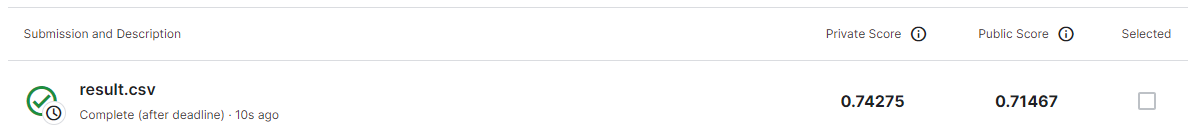

In [2]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

### 이미지 전처리

In [3]:

"./plant-pathology-2020-fgvc7/images/"

IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "./plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "./plant-pathology-2020-fgvc7/sample_submission.csv"

test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    
    # 이미지 크기 확인
    height, width, _ = image.shape
    
    # 이미지 크기가 (2048, 1365)일 경우 회전하여 크기 변경
    if height == 2048 and width == 1365:
        image = np.rot90(image)

    # 이미지를 1/4 크기로 줄이기
    image = cv2.resize(image, (341, 512))
    
    image = image.astype('float32')/255

    return image

    #return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["image_id"][:].apply(load_image)



In [4]:
train_images = np.stack(train_images)

In [5]:
train_images2 = np.flip(train_images, axis=2)

In [6]:
train_images3 = np.flip(train_images, axis=1)

In [7]:
train_images = np.concatenate((train_images, train_images2, train_images3), axis=0)

In [8]:
labels = train_data[["healthy", "multiple_diseases", "rust", "scab"]].values

In [9]:
labels = np.concatenate((labels, labels, labels), axis=0)

In [10]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), input_shape=(512,341,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
"""
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), input_shape=(512,341,3), activation='relu'))
#model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(4,4)))
#model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#model.add(Dropout(0.25))
#model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
#model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
"""

"\nmodel = Sequential()\nmodel.add(Conv2D(16, kernel_size=(3,3), input_shape=(512,341,3), activation='relu'))\n#model.add(Dropout(0.25))\nmodel.add(MaxPooling2D(pool_size=(4,4)))\n#model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))\n#model.add(Dropout(0.25))\n#model.add(MaxPooling2D(pool_size=(4,4)))\nmodel.add(Flatten())\n#model.add(Dropout(0.25))\nmodel.add(Dense(32, activation='relu'))\n#model.add(Dropout(0.1))\nmodel.add(Dense(16, activation='relu'))\n#model.add(Dropout(0.1))\nmodel.add(Dense(4, activation='softmax'))\n\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n"

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 339, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 84, 16)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 170688)            0         
                                                                 
 dense (Dense)               (None, 32)                5462048   
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                        

In [14]:
modelpath = './test.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='loss', patience=10)

#history = None
#import tensorflow as tf
#with tf.device("/device:GPU:1")
history=model.fit(train_images, labels, epochs=70, batch_size=500, verbose=1, callbacks=[early_stopping_callback, checkpointer])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.